Observation: I'm gonna try out a bigger horizon

**0. Installing Dependencies**

In [157]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels -q


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [158]:
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
total = 29000

**1. Retrieving Data**

In [159]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Dataframe in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=total)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


1.1 Aggregate Data by day

In [160]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)



In [161]:
df['Zeitstempel'] = pd.to_datetime(df['Zeitstempel'])
df = df.set_index('Zeitstempel')
df = df.resample('24H').sum()
df = df.drop(df.tail(1).index)

Recalculate total by 24h

In [162]:
total = int ((total / 96) -1) 
print(total)

301


**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [163]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

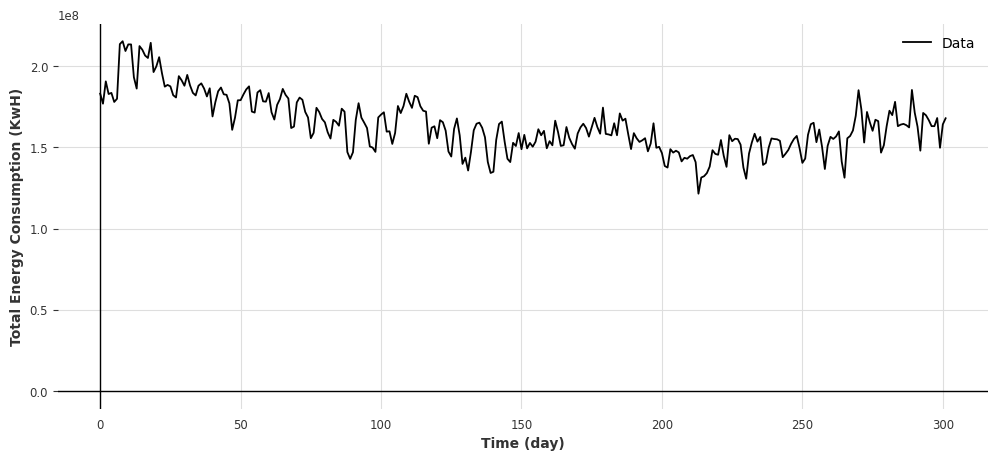

In [164]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label='Data')
plt.xlabel('Time (day)')
plt.ylabel('Total Energy Consumption (KwH)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.plot(range(len(energy_consumption_data), len(energy_consumption_data)))
plt.legend()
plt.show()

We're going to generate a darts time_series version of the data

In [165]:
from darts import TimeSeries
time_series = TimeSeries.from_values(energy_consumption_data)


Train an AutoRegression (AR) Model, using ARModel from module 8

Splitting data to 90, 10% training testing

In [166]:
train, test = time_series.split_before(0.9)  

Initialiser notre model

In [167]:
p = 10

In [168]:
from darts.models import ARIMA
arima_model = ARIMA(p)
arima_model.fit(train)

ARIMA(p=10, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

Prediction of test data

We use .predict to forecast the next `len(test)` values

I'm going to use statsmodels for AR

In [169]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [170]:
lags = 10
model = AutoReg(energy_consumption_data, lags)
model_fitted = model.fit()   
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  302
Model:                    AutoReg(10)   Log Likelihood               -5020.900
Method:               Conditional MLE   S.D. of innovations        7102254.434
Date:                Wed, 30 Apr 2025   AIC                          10065.799
Time:                        08:13:45   BIC                          10109.920
Sample:                            10   HQIC                         10083.472
                                  302                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.108e+07   4.51e+06      2.458      0.014    2.24e+06    1.99e+07
y.L1           0.6620      0.058     11.362      0.000       0.548       0.776
y.L2          -0.0963      0.070     -1.379      0.1

In [171]:
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)
print(forecast)


[1.67589211e+08 1.61732904e+08 1.65782626e+08 1.62561942e+08
 1.57585097e+08 1.62367557e+08 1.64806795e+08 1.64255041e+08
 1.62637227e+08 1.64212009e+08 1.61413924e+08 1.59973907e+08
 1.61596087e+08 1.62930171e+08 1.62525837e+08 1.62475351e+08
 1.62716398e+08 1.61206178e+08 1.60587554e+08 1.61198759e+08
 1.61755018e+08 1.61646530e+08 1.61856125e+08 1.61749411e+08
 1.60992252e+08 1.60647968e+08 1.60863260e+08 1.61048593e+08
 1.61080027e+08 1.61234016e+08 1.61108812e+08 1.60720204e+08
 1.60514654e+08 1.60557166e+08 1.60601606e+08 1.60653992e+08
 1.60734782e+08 1.60648492e+08 1.60442175e+08 1.60314251e+08
 1.60289880e+08 1.60286433e+08 1.60319851e+08 1.60354887e+08
 1.60300520e+08 1.60187355e+08 1.60103848e+08 1.60061937e+08
 1.60043321e+08 1.60055566e+08 1.60065874e+08 1.60030819e+08
 1.59965865e+08 1.59909149e+08 1.59868918e+08 1.59846739e+08
 1.59845119e+08 1.59842907e+08 1.59818716e+08 1.59778934e+08
 1.59739321e+08 1.59706173e+08 1.59684855e+08 1.59676183e+08
 1.59668220e+08 1.596501

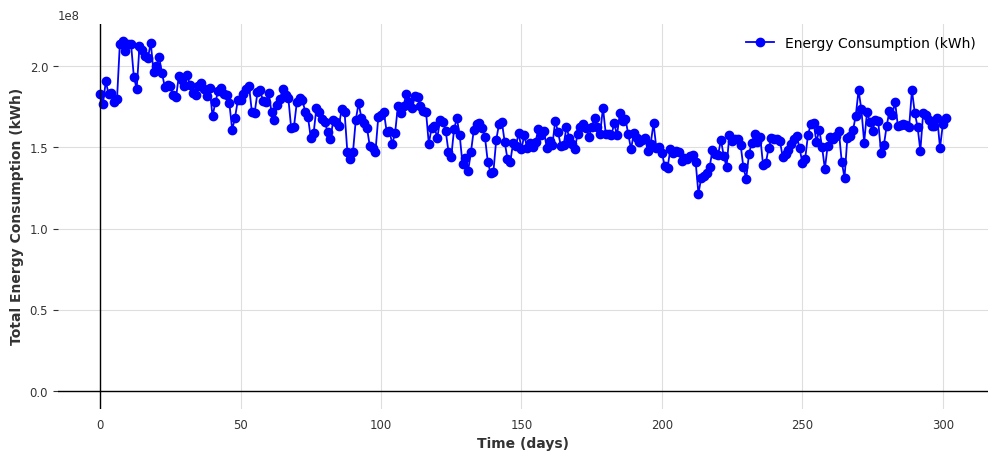

In [172]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label="Energy Consumption (kWh)", color='blue', marker='o')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.ylabel("Total Energy Consumption (kWh)")
plt.legend()
plt.show()



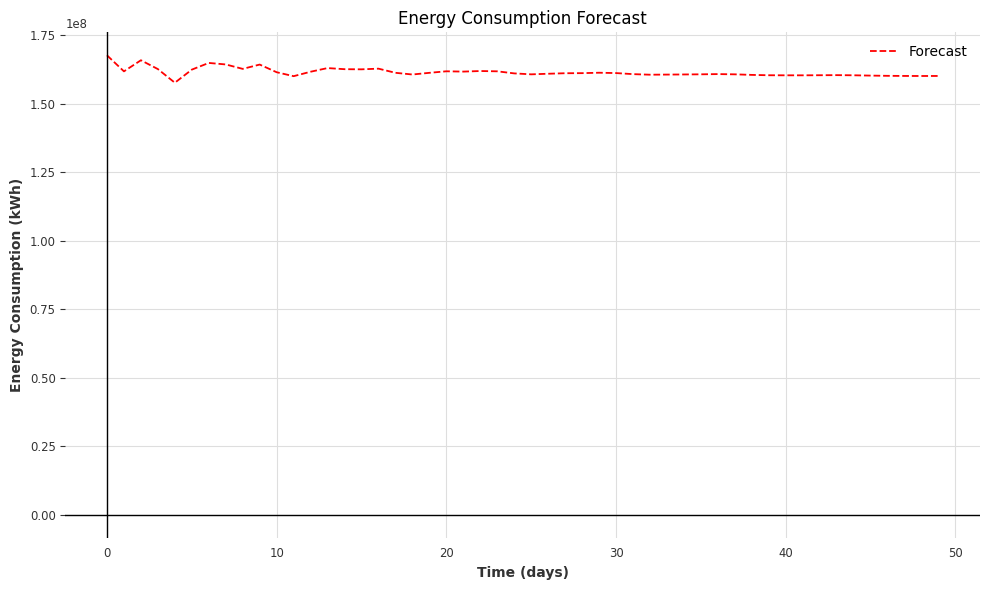

In [173]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')

plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Going to create a combined dataset: 300 last actual points and 50 forecasted points


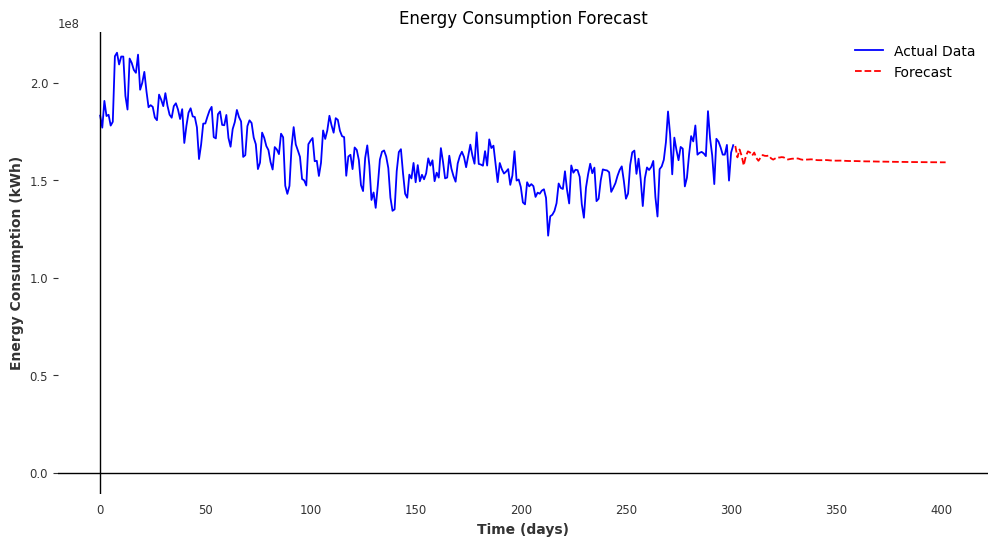

In [174]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


on teste avec lag = 30

In [175]:
model = AutoReg(energy_consumption_data, lags=30)  
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)

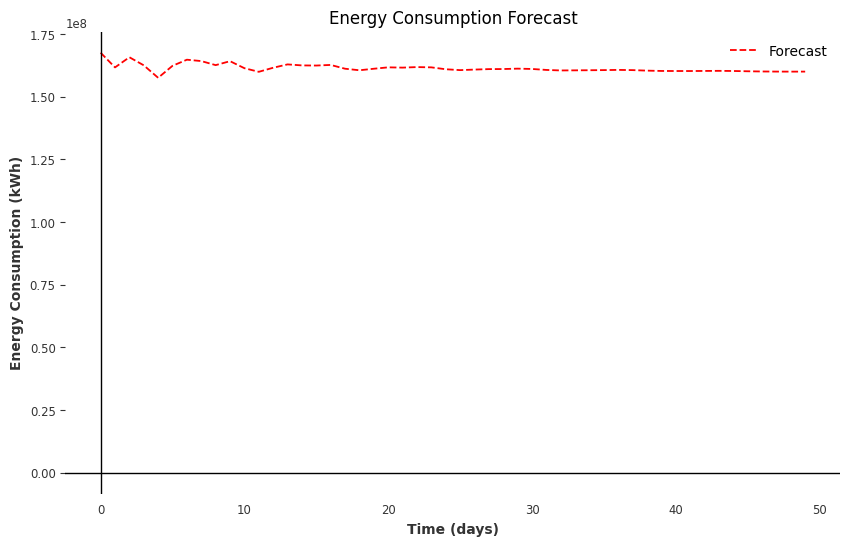

In [176]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')

plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

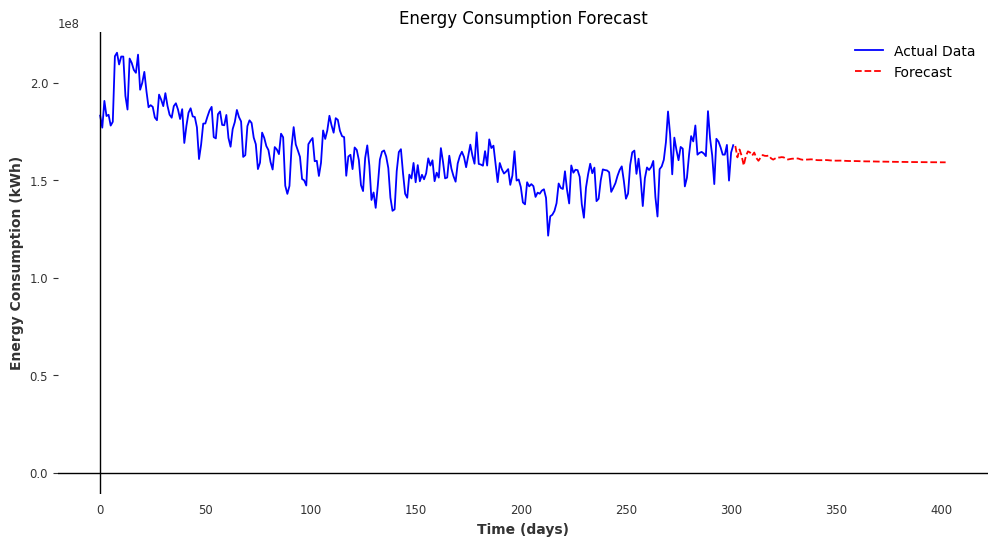

In [177]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


Vector Auto-regression

Je vais utiliser statsmodels pour VAR

Data cleaning, converts everything to numeric, replacing errors with NaN

In [178]:
print(df)

             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-01-01                               1.361635e+08   
2024-01-02                               1.475919e+08   
2024-01-03                               1.529386e+08   
2024-01-04                               1.580906e+08   
2024-01-05                               1.654799e+08   
...                                               ...   
2024-10-24                               1.413813e+08   
2024-10-25                               1.401766e+08   
2024-10-26                               1.239567e+08   
2024-10-27                               1.170852e+08   
2024-10-28                               1.381239e+08   

             Total Energy Production (kWh)  Total Energy Consumption (kWh)  \
Zeitstempel                                                                  
2024-01-01                    1.296562e+08                    1.831487e+08   
2024-01-02              

In [179]:
df = df.apply(pd.to_numeric, errors='coerce') 

Only going to consider first 6 rows

In [180]:
df = df.iloc[:, :6]

In [181]:
df_cleaned = df.dropna()

Split testing 20-80 ish

In [182]:
test_total = int(0.2*300)

In [183]:
train_data = df.iloc[:-test_total]  
test_data = df.iloc[-test_total:]  

Initialize VAR model

In [184]:
from statsmodels.tsa.api import VAR
model = VAR(train_data)

choose how many last values to rely on: here =5

In [185]:
print(df.shape)  

(302, 6)


In [186]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  


In [187]:
p = 6
fitted_model = model.fit(p) 

forecast next 20%

In [188]:
forecast = fitted_model.forecast(train_data.values[-p:], steps=test_total) 

In [189]:
correlation_matrix = df.corr()
print(correlation_matrix)


                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                  1.000000   
Total Energy Production (kWh)                                            -0.064989   
Total Energy Consumption (kWh)                                            0.892140   
Net Outflow (kWh)                                                         0.368196   
Grid Feed-In (kWh)                                                        0.021612   
Positive Secondary Control Energy (kWh)                                   0.343144   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                      -0.064989   
Total Energy Production (kWh)                                  1.000000   
Total Energy Consumption (kWh)                                -0.195994   
Net Outflow (kWh)                                             -0.539762   
Grid Feed-In (kWh)    

Trouver tout les variables très corrolées

In [190]:
correlation_threshold = 0.9
high_correlation = correlation_matrix.abs() > correlation_threshold
print(high_correlation)

                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                      True   
Total Energy Production (kWh)                                                False   
Total Energy Consumption (kWh)                                               False   
Net Outflow (kWh)                                                            False   
Grid Feed-In (kWh)                                                           False   
Positive Secondary Control Energy (kWh)                                      False   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                          False   
Total Energy Production (kWh)                                      True   
Total Energy Consumption (kWh)                                    False   
Net Outflow (kWh)                                                 False   
Grid Feed-In (kWh)    

In [191]:
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

I'm going to compare forecast with actual data for the same rows

In [192]:
from statsmodels.tools.eval_measures import rmse

print("Forecast:")
print(forecast_df)


Forecast:
             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-08-30                               1.370782e+08   
2024-08-31                               1.244544e+08   
2024-09-01                               1.230497e+08   
2024-09-02                               1.290325e+08   
2024-09-03                               1.314795e+08   
2024-09-04                               1.329195e+08   
2024-09-05                               1.361297e+08   
2024-09-06                               1.335096e+08   
2024-09-07                               1.268282e+08   
2024-09-08                               1.267967e+08   
2024-09-09                               1.301474e+08   
2024-09-10                               1.312354e+08   
2024-09-11                               1.330395e+08   
2024-09-12                               1.350264e+08   
2024-09-13                               1.325797e+08   
2024-09-14           

Root mean square deviation for average difference between values predicted by a model and the actual values

In [193]:
rmse_score = rmse(test_data, forecast_df)
print(f"RMSE: {rmse_score}")

RMSE: [10573099.53187188 29086623.00061338 11399462.00544798  3544050.47164713
 25251109.68430102   159659.02540381]


In [194]:
def plot_actual_vs_forecasted(col):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test_data.index,     test_data[col],     '--', color='blue', label=f'Actual {col}')
    ax.plot(forecast_df.index, forecast_df[col], '-',  color='red',  label=f'Forecast {col}')

    ax.set_title(f'Actual vs Forecasted {col}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(test_data.index[0], color='black', linewidth=1)
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

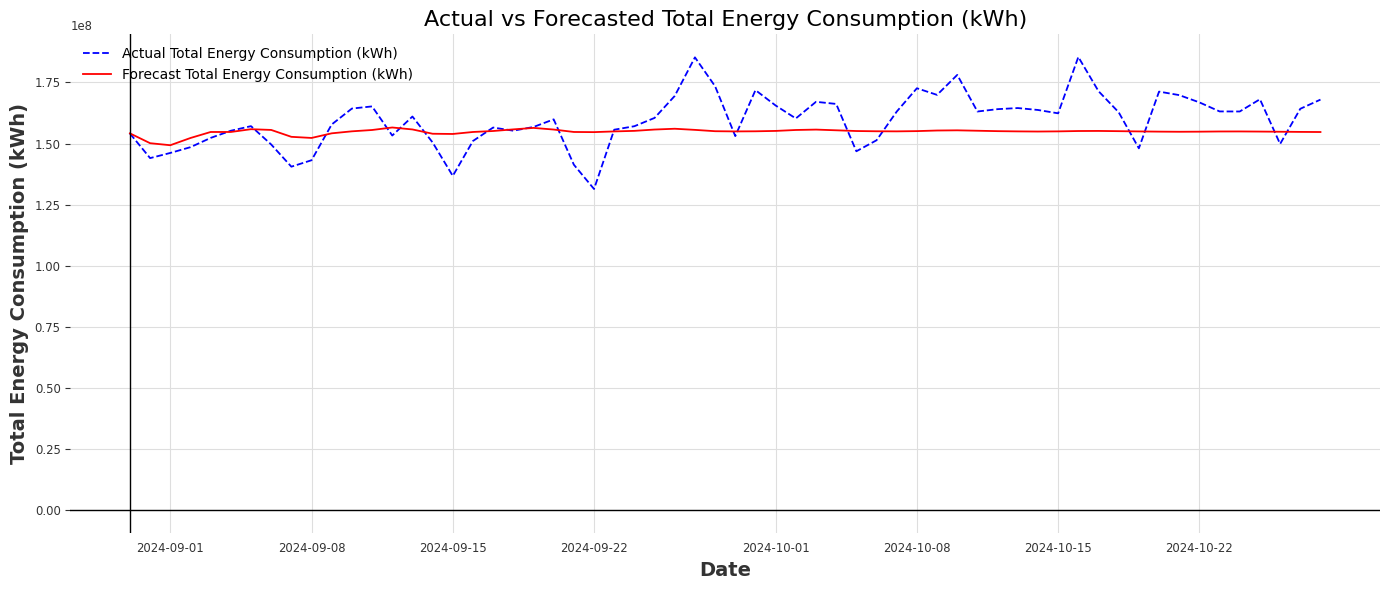

In [195]:
plot_actual_vs_forecasted('Total Energy Consumption (kWh)')

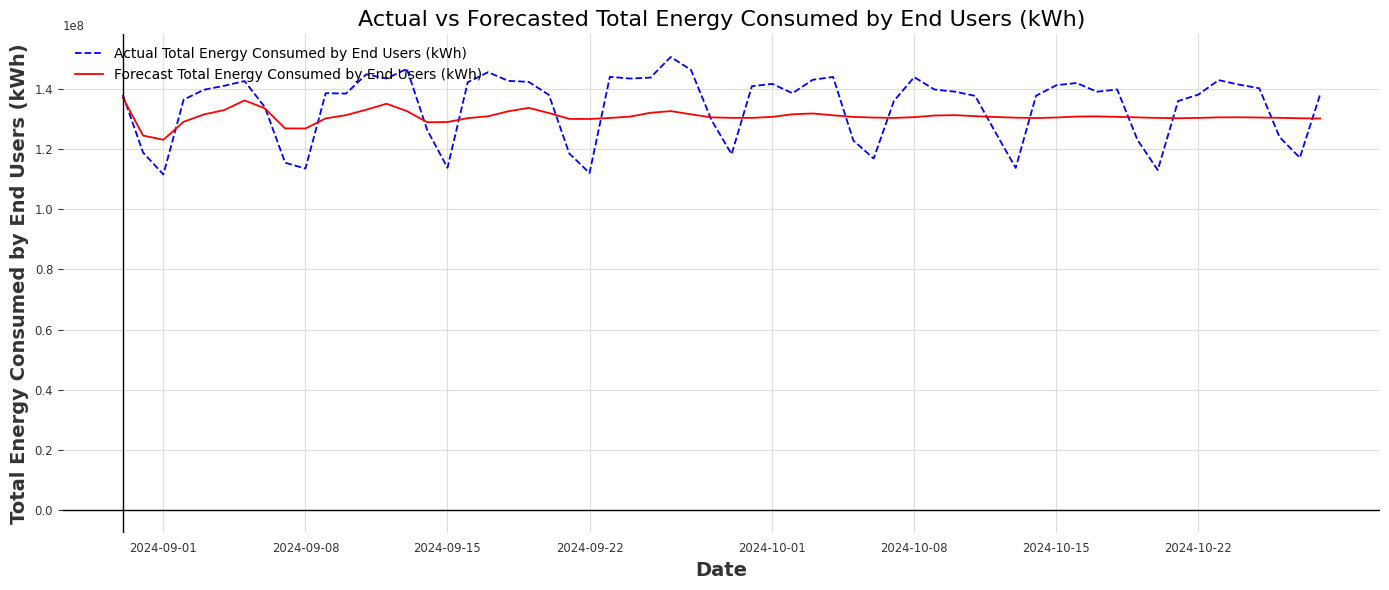

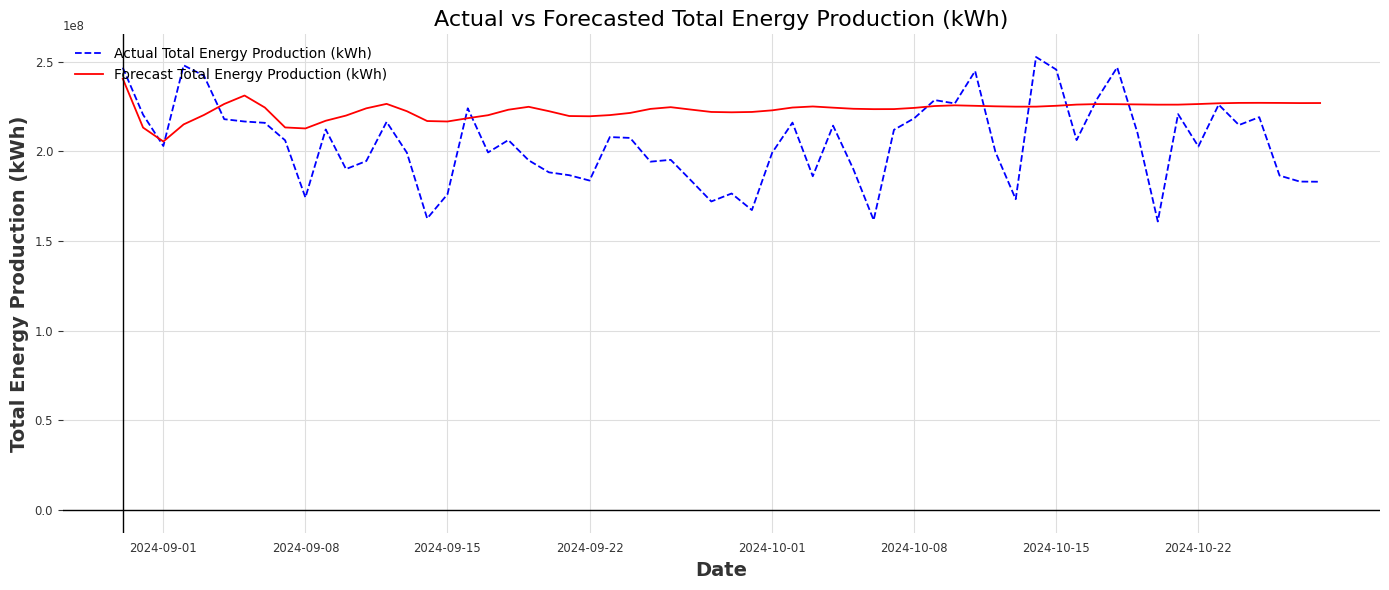

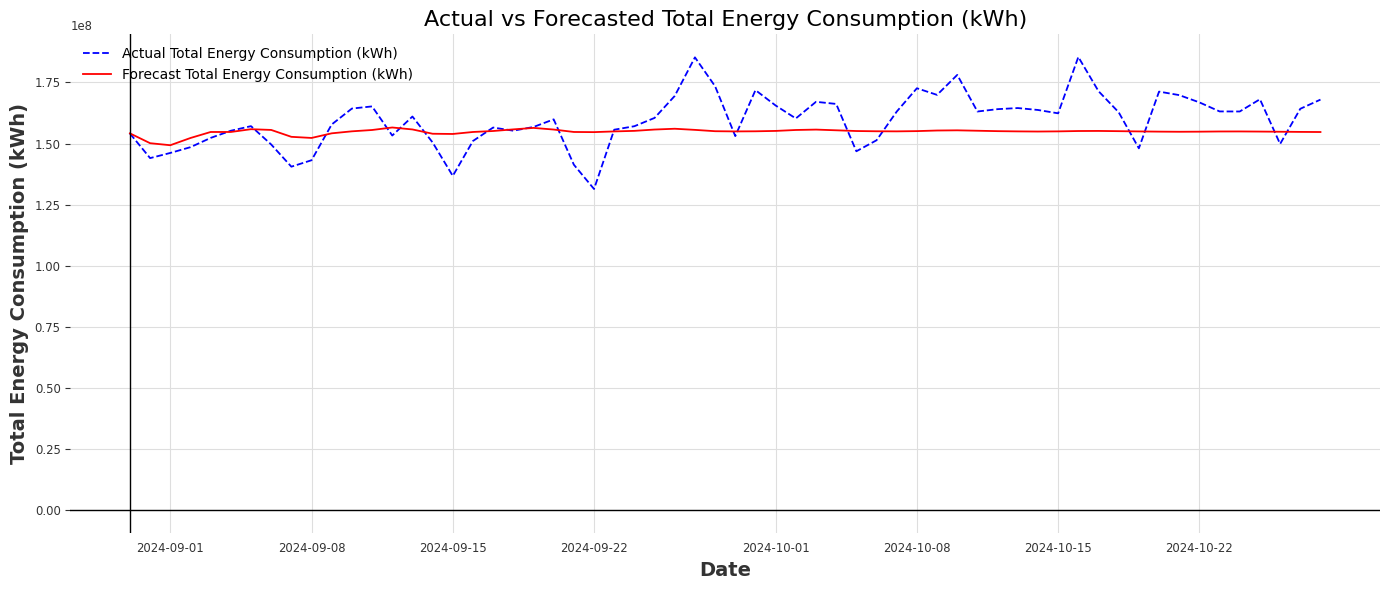

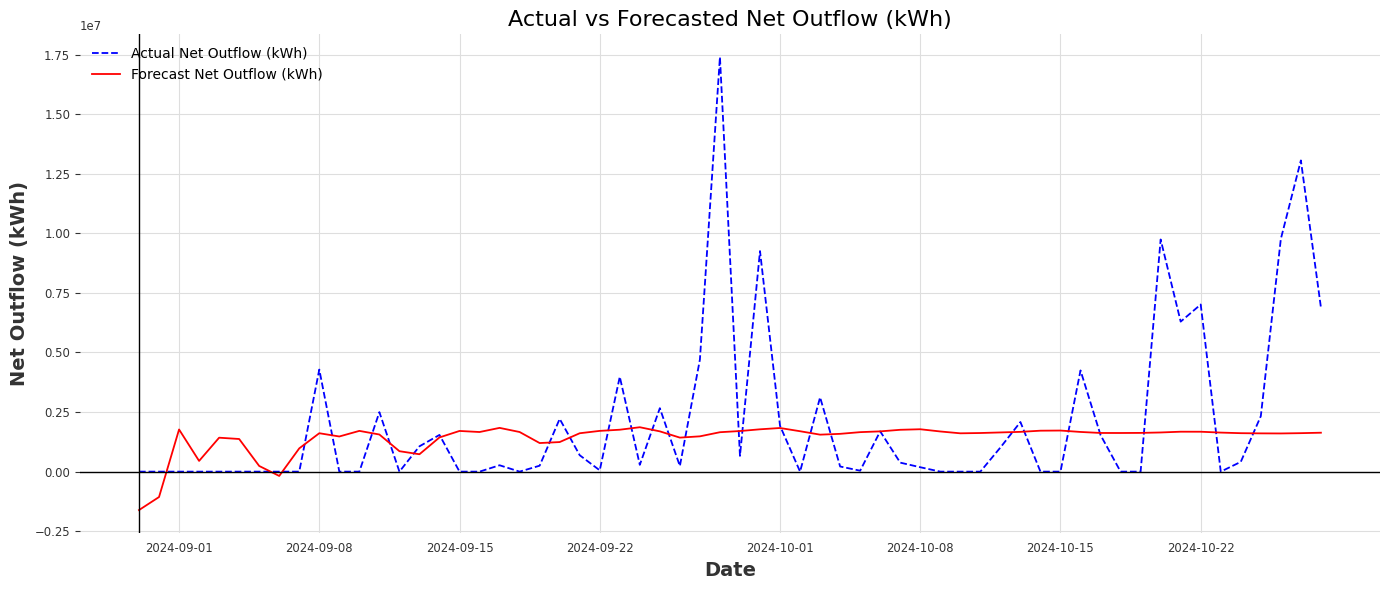

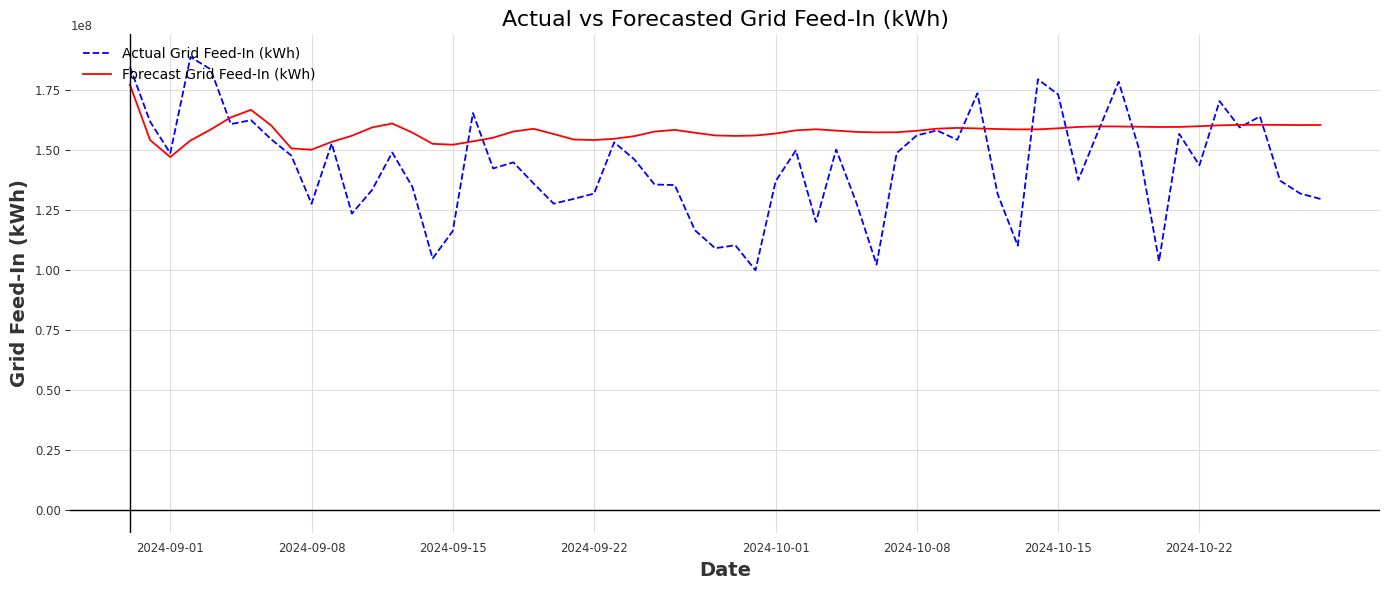

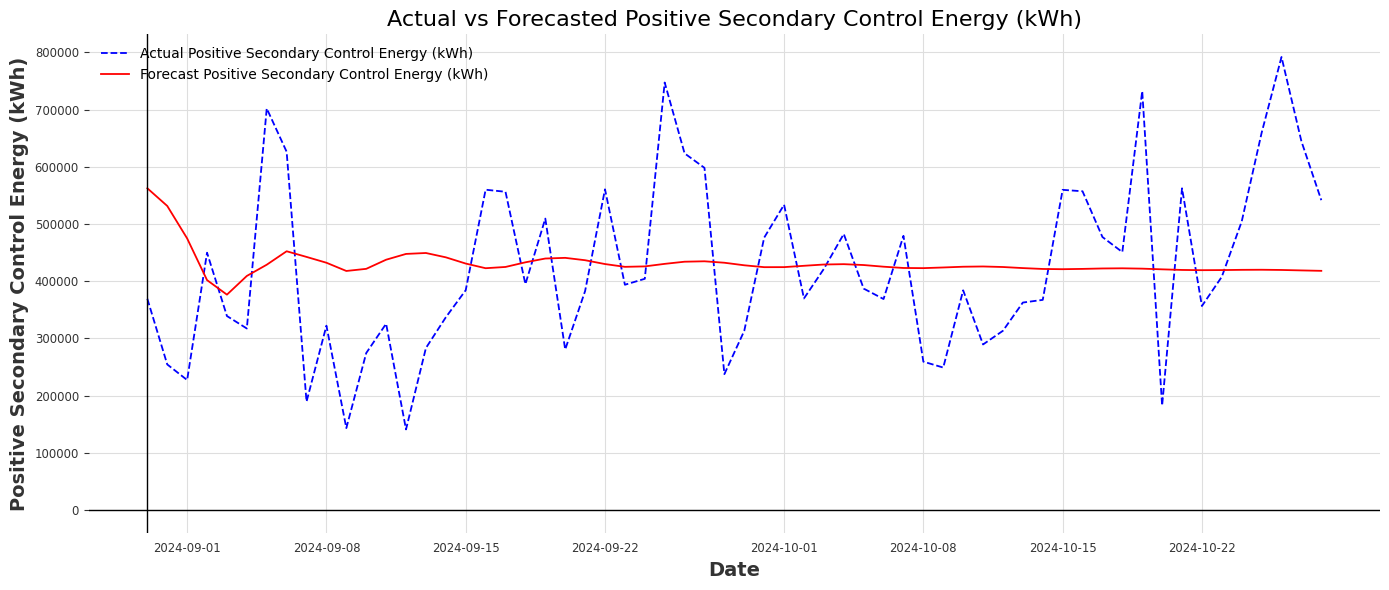

In [196]:
for col in forecast_df.columns:
    plot_actual_vs_forecasted(col)